In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import random
import shutil

In [2]:
def load_random_files(input_folder, output_folder, num_files_to_keep):
    # Create output directory if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for root, dirs, files in os.walk(input_folder):
        # Create corresponding subfolders in the output directory
        rel_path = os.path.relpath(root, input_folder)
        output_subfolder = os.path.join(output_folder, rel_path)
        if not os.path.exists(output_subfolder):
            os.makedirs(output_subfolder)
        
        # Randomly select files to keep
        files_to_keep = random.sample(files, min(num_files_to_keep, len(files)))
        
        # Copy selected files to the output subfolder
        for file in files_to_keep:
            source_path = os.path.join(root, file)
            dest_path = os.path.join(output_subfolder, file)
            shutil.copy(source_path, dest_path)

# Example usage:
input_folder = r"C:\Users\yoihe\Desktop\asl_alphabet\asl_alphabet_train"
output_folder = r"C:\Users\yoihe\Desktop\asl_alphabet\maintest"
num_files_to_keep = 250  # Adjust as needed

load_random_files(input_folder, output_folder, num_files_to_keep)

In [3]:
# Function to load images and labels from a directory
def load_images_from_folder(folder):
    images = []
    labels = []
    for subfolder in os.listdir(folder):
        subfolder_path = os.path.join(folder, subfolder)
        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
                img_path = os.path.join(subfolder_path, filename)
                try:
                    img = Image.open(img_path)
                    img = img.resize((64, 64))  # Resize image to a common size
                    img = np.array(img)
                    images.append(img.flatten())  # Flatten image
                    labels.append(subfolder)
                except Exception as e:
                    print(f"Error loading image: {e}")
    return np.array(images), np.array(labels)

# Load images and labels
data_folder = r"C:\Users\yoihe\Desktop\asl_alphabet\maintext1"
images, labels = load_images_from_folder(data_folder)


In [4]:
# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)


In [11]:
# Define individual classifiers
svm_clf = SVC(kernel='rbf', gamma='scale', random_state=42, probability=True)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42,)

# Create ensemble classifier using VotingClassifier
ensemble_clf = VotingClassifier(estimators=[('svm', svm_clf), ('rf', rf_clf)], voting='soft')


In [12]:
# Train the ensemble model
ensemble_clf.fit(X_train, y_train)


VotingClassifier(estimators=[('svm', SVC(probability=True, random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42))],
                 voting='soft')

In [15]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
svm_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
# Make predictions for all classifiers in the ensemble model
y_pred_ensemble = ensemble_clf.predict(X_test)
y_pred_rf = rf_clf.predict(X_test)
y_pred_svm = svm_clf.predict(X_test)

# Calculate and print accuracy scores for all classifiers
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy - Ensemble:", accuracy_ensemble)
print("Accuracy - Random Forest:", accuracy_rf)
print("Accuracy - Support Vector Machine:", accuracy_svm)

# Calculate and print classification reports for all classifiers
print("Classification Report - Ensemble:")
print(classification_report(y_test, y_pred_ensemble))

print("Classification Report - Random Forest:")
print(classification_report(y_test, y_pred_rf))

print("Classification Report - Support Vector Machine:")
print(classification_report(y_test, y_pred_svm))

# Calculate and print ROC-AUC scores for all classifiers (if applicable)
if hasattr(ensemble_clf, "predict_proba"):
    y_prob_ensemble = ensemble_clf.predict_proba(X_test)[:, 1]
    roc_auc_ensemble = roc_auc_score(y_test, y_prob_ensemble)
    print("ROC-AUC - Ensemble:", roc_auc_ensemble)

if hasattr(rf_clf, "predict_proba"):
    y_prob_rf = rf_clf.predict_proba(X_test)[:, 1]
    roc_auc_rf = roc_auc_score(y_test, y_prob_rf)
    print("ROC-AUC - Random Forest:", roc_auc_rf)

if hasattr(svm_clf, "decision_function"):
    y_score_svm = svm_clf.decision_function(X_test)
    roc_auc_svm = roc_auc_score(y_test, y_score_svm)
    print("ROC-AUC - Support Vector Machine:", roc_auc_svm)



Accuracy - Ensemble: 0.8855172413793103
Accuracy - Random Forest: 0.9289655172413793
Accuracy - Support Vector Machine: 0.5744827586206896
Classification Report - Ensemble:
              precision    recall  f1-score   support

           A       0.84      0.82      0.83        57
           B       0.73      0.84      0.78        55
           C       0.88      0.81      0.85        54
           D       0.78      0.81      0.79        36
           E       0.84      0.88      0.86        52
           F       0.79      0.86      0.82        65
           G       0.80      0.91      0.85        45
           H       0.97      0.83      0.89        46
           I       0.95      1.00      0.97        55
           J       0.96      0.92      0.94        51
           K       0.98      0.84      0.91        51
           L       0.97      0.90      0.94        42
           M       0.96      0.86      0.91        51
           N       0.96      0.96      0.96        47
           O    

ValueError: multi_class must be in ('ovo', 'ovr')

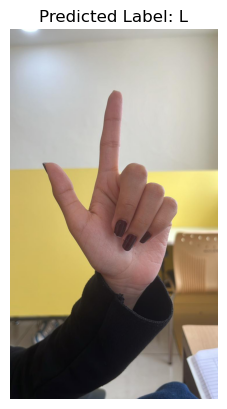

In [16]:
# Function to classify a single image
def classify_image(image_path):
    img = Image.open(image_path)
    img = img.resize((64, 64))  # Resize image to match training data
    img = np.array(img)
    img_flattened = img.flatten().reshape(1, -1)  # Flatten image
    prediction = ensemble_clf.predict(img_flattened)
    return prediction[0]

# Function to visualize the classification
def visualize_classification(image_path):
    predicted_label = classify_image(image_path)
    img = Image.open(image_path)
    plt.imshow(img)
    plt.title(f"Predicted Label: {predicted_label}")
    plt.axis('off')
    plt.show()

# Example usage: Visualize classification of a single image
image_path = r"C:\Users\yoihe\Downloads\39628280-2405-4218-b9b7-9ed5b64bbbb8.jpeg"
visualize_classification(image_path)
